# IMPORT MODULES

In [1]:
import numpy as np # for text file data
from scipy.interpolate import interp1d # for interpolating points
import matplotlib.pyplot as plt # for plotting
%matplotlib inline
import pandas as pd # for working with dataframes
from sklearn.decomposition import PCA # for principal component analysis
import math # for math
from math import atan2, degrees


/Users/chitwood/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


# FUNCTIONS

In [2]:
# define a function to return equally spaced, interpolated points for a given polyline
# inputs: arrays of x and y values for a polyline, number of points to interpolate
# ouputs: interpolated points along the polyline, inclusive of start and end points

def interpolation(x, y, number): 

    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

# define a function to replace points in trace file with nearest landmarks, 
# and return modified trace files and indices of landmarks in the trace
# inputs: arrays with x and y coordinates for the landmarks and trace, total resolution to interpolate over
# outputs: the indices of the landmarks in the returned modified trace files, now at specified resolution

def replace_with_landmarks(landmarks_file, trace_file, resolution):
    
    trace_xvals = trace_file[:,0] # specify trace xvals
    trace_yvals = trace_file[:,1] # specify trace yvals

    trace_xvals, trace_yvals = interpolation(trace_xvals,trace_yvals,resolution) # interpolate points to achieve high resolution

    new_xvals = trace_xvals # copy trace xvals to replace its trace vals with landmark vals
    new_yvals = trace_yvals # copy trace yvals to replace its trace vals with landmark vals

    land_indices = [] # list to store index values of landmarks in trace

    for i in range(landmarks_file.shape[0]): # for each landmark

        landx = landmarks_file[i,0] # select current landmark x val
        landy = landmarks_file[i,1] # select current landmark y val

        distances = [] # list to store distances of current landmark with each trace coord

        for j in range(len(trace_xvals)): # for each trace coord

            tracex = trace_xvals[j] # current trace x val
            tracey = trace_yvals[j] # current trace y val

            d = np.sqrt( (landx-tracex)**2 + (landy-tracey)**2 ) # find distance to each landmark for each trace

            distances.append(d) # append distance of landmark to each trace val

        min_val = np.min(distances) # find min distance value of a trace for the landmark
        min_ind = distances.index(min_val) # find min index value among trace coords to the landmark

        new_xvals[min_ind] = landx # change the trace x val to the landmark x val
        new_yvals[min_ind] = landy # change the trace y val to the landmark y val

        land_indices.append(min_ind) # append trace index that corresponds to landmark
        
    return land_indices, new_xvals, new_yvals

# define a function to return interpolated points for each interval between landmarks of a trace file
# inputs: landmark indices, xvals and yvals of polyline at desired resolution,
# number of interpolated landmarks per interval
# outputs: lists of x and y values with specified number of interpolated points per interval

def interpolated_intervals(land_indices, new_xvals, new_yvals, num_land):
    
    inter_points_x = [] # list to store interpolated x vals
    inter_points_y = [] # list to store interpolated y vals

    for i in range(len(land_indices)-1): # for each index, minus 1, because we are analyzing intervals

        beg_ind = land_indices[i] # specify the beginning point, based on index
        end_ind = land_indices[i+1] # specify the end point, based on index

        interval_xvals = new_xvals[beg_ind:end_ind] # using indices above, find the interval of x vals
        interval_yvals = new_yvals[beg_ind:end_ind] # using indices above, find the interval of y vals

        curr_inter_xvals, curr_inter_yvals = interpolation(interval_xvals, interval_yvals, num_land) # interpolate the interval

        curr_inter_xvals = list(curr_inter_xvals) # convert interval x vals into a list
        curr_inter_yvals = list(curr_inter_yvals) # convert interval y vals into a list

        # to prevent duplicated pseudo-landmark points, because we are working with intervals:

        if i==0: # if the first interval, delete the end point, because it will be covered in the next interval

            del curr_inter_xvals[-1]
            del curr_inter_yvals[-1]

        if i!=0: # if not the first interval, delete the start point, because it was covered in the previous interval

            del curr_inter_xvals[0]
            del curr_inter_yvals[0]

        for j in range(len(curr_inter_xvals)): # for the current interval points

            inter_points_x.append(curr_inter_xvals[j]) # append current interval x vals to list
            inter_points_y.append(curr_inter_yvals[j]) # append current interval y vals to list

    return inter_points_x, inter_points_y

# define a function taking landmark and vein and blade trace files interpolated outlines
# at specified number of landmarks per interval calculated from specified resolution
# inputs: landmark and vein and blade trace files, number of landmarks per interval, resolution
# outputs: interpolated x vals and y vals for the veins and blade, vein and blade landmarks

def interpolated_leaf(landmarks_file, vein_trace_file, blade_trace_file, num_land, resolution):

    # select vein and blade landmarks
    vein_landmarks = landmarks_file[0:65,:]
    blade_landmarks = landmarks_file[[0,2,65,5,66,8,10,68,13,69,16,70,19,71,21,72,24,73,27,74,30,75,32,76,34,77,37,78,40,79,43,80,45,81,48,82,51,83,54,84,56,85,59,86,62,64],:]

    # interpolate vein points
    vein_land_indices, vein_new_xvals, vein_new_yvals = replace_with_landmarks(vein_landmarks, vein_trace_file, resolution)
    vein_xvals, vein_yvals = interpolated_intervals(vein_land_indices, vein_new_xvals, vein_new_yvals, num_land)

    # interpolate blade points
    blade_land_indices, blade_new_xvals, blade_new_yvals = replace_with_landmarks(blade_landmarks, blade_trace_file, resolution)
    blade_xvals, blade_yvals = interpolated_intervals(blade_land_indices, blade_new_xvals, blade_new_yvals, num_land)

    return vein_xvals, vein_yvals, blade_xvals, blade_yvals

# define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
# inputs: three angle points, as tuples
# output: angle in degrees

def angle_between(p1, p2, p3):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

# define a function to rotate 2D x and y coordinate points around the origin
# inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
# outputs: rotated and y vals

def rotate_points(xvals, yvals, degrees):
    
    angle_to_move = 270 - degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

# define a function to rotate tip downwards, scale to centimeters, and translate petiolar junction to the origin
# inputs: interpolated x and y vein and blade values, landmarks, and px2 to cm2 scale
# outputs: rotated, scaled, and translated landmark, vein, and blade coordinates

def rotate_and_scale(vein_xvals, vein_yvals, blade_xvals, blade_yvals, landmarks, px2_cm2, filename):
    
    land_arr = landmarks # create landmarks coordinates array
    vein_arr = np.column_stack((vein_xvals, vein_yvals)) # create vein coordinates array
    blade_arr = np.column_stack((blade_xvals, blade_yvals)) # create blade coordinates array

    land_len = np.shape(landmarks)[0] # get lengths of landmark, vein, and blade arrays to retrieve coords later
    vein_len = np.shape(vein_arr)[0]
    blade_len = np.shape(blade_arr)[0]
    overall_len = land_len + vein_len + blade_len

    overall_arr = np.row_stack((landmarks, vein_arr, blade_arr)) # stack land, vein, blade arrays into single array

    px_cm = np.sqrt(px2_cm2) # take square root of scaling factor to scale pixels to cm
    scaled_arr = overall_arr/px_cm # convert pixels into 
    tip_to_base_cm = np.sqrt((scaled_arr[32,0]-scaled_arr[0,0])**2  # get distance in pixels from tip to base of leaf
                             + (scaled_arr[32,1]-scaled_arr[0,1])**2) # use to scale PC values back to cm later
    
    # perform a principal component analysis on data to center
    
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(overall_arr)
    df = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
    
    # find the angle of the leaf tip relative to the origin
    
    p1 = (df["pc1"].loc[32,], df["pc2"].loc[32,]) # get leaf tip PC1/PC2 coordinate value
    p2 = (0,0) # find angle relative to vertex at origin
    p3 = (10,0) # an arbitrary positive point along the x axis to find angle in anticlockwise direction

    angle = angle_between(p1, p2, p3) # find the angle in degrees of tip point relative to origin, anticlockwise

    rotated_xvals, rotated_yvals = rotate_points(df["pc1"], df["pc2"], angle)

    rotated_arr = np.column_stack((rotated_xvals, rotated_yvals)) # stack x and y vals back into one array

    tip_to_base_pca = np.sqrt((rotated_arr[32,0]-rotated_arr[0,0])**2 # find the distance in PC vals between tip and base
                              + (rotated_arr[32,1]-rotated_arr[0,1])**2)

    scale = tip_to_base_cm/tip_to_base_pca # find the factor to scale back to cm

    scaled_arr = rotated_arr*scale # scale rotated PC vals back to cm
    
    pet_junc = np.mean(scaled_arr[[0,64],:],axis=0)
    
    trans_x = scaled_arr[:,0] - pet_junc[0]
    trans_y = scaled_arr[:,1] - pet_junc[1]
    
    scaled_arr = np.column_stack((trans_x, trans_y))
    
    if scaled_arr[10,0] < 0: # insure left side of the leaf is left so labels are on right side of plot
        scaled_arr[:,0] = -scaled_arr[:,0]
        
    scaled_land = scaled_arr[0:land_len,] # isolate just landmarks
    scaled_vein = scaled_arr[land_len:(land_len+vein_len),] # isolate just vein coords
    scaled_blade = scaled_arr[(land_len+vein_len):(land_len+vein_len+blade_len),] # isolate just blade coords
    
    np.savetxt("./landmarks/" + filename + "_scaled_landmarks.txt", scaled_land) # save landmark data to landmarks folder
    np.savetxt("./landmarks/" + filename + "_scaled_veins.txt", scaled_vein) # save vein data to landmarks folder
    np.savetxt("./landmarks/" + filename + "_scaled_blade.txt", scaled_blade) # save vein data to landmarks folder
    
    return scaled_land, scaled_vein, scaled_blade # return scaled and rotated landmarks, vein, and blade

# define a function to calculate Galet ampelographic traits and plot leaf, as defined in A Practical Ampelography
# inputs: rotated, scaled, translated landmark, vein, and blade coordinates, plot parameters
# outputs: ampelographic parameters, saved image file to folder /data

def galet_ampelography(scaled_land, scaled_vein, scaled_blade, blade_color, blade_outline_color, vein_color, blade_outline_lw, text_position, offset, fontsize, linewidth, filename):    
    
    ####################################################
    # How to Measure and Encode the Lengths of the Veins
    # page 45 Cornell edition A Practical Ampelography
    ####################################################

    pet_junc = np.mean(scaled_land[[0,64],:],axis=0)
    L1 = scaled_land[32,:]
    L2 = scaled_land[21,:] # calculate points for left side
    L3 = scaled_land[10,:]
    L4 = scaled_land[2,:]
    pet_vein = np.mean(scaled_land[[1,3],:],axis=0)

    L2p = scaled_land[43,:] # calculate points for right side
    L3p = scaled_land[54,:]
    L4p = scaled_land[62,:]
    pet_veinp = np.mean(scaled_land[[61,63],:],axis=0)

    L1_len = np.sqrt((L1[0]-pet_junc[0])**2 + (L1[1]-pet_junc[1])**2) # calculate lengths for left side
    L2_len = np.sqrt((L2[0]-pet_junc[0])**2 + (L2[1]-pet_junc[1])**2)
    L3_len = np.sqrt((L3[0]-pet_junc[0])**2 + (L3[1]-pet_junc[1])**2)
    L4_len = np.sqrt((L4[0]-pet_vein[0])**2 + (L4[1]-pet_vein[1])**2)

    L2p_len = np.sqrt((L2[0]-pet_junc[0])**2 + (L2[1]-pet_junc[1])**2) # calculate lengths for right side
    L3p_len = np.sqrt((L3[0]-pet_junc[0])**2 + (L3[1]-pet_junc[1])**2)
    L4p_len = np.sqrt((L4[0]-pet_vein[0])**2 + (L4[1]-pet_vein[1])**2)

    A = L2_len/L1_len # calculate ratios for left side
    B = L3_len/L1_len
    C = L4_len/L1_len

    Ap = L2p_len/L1_len # calculate ratios for right side
    Bp = L3p_len/L1_len
    Cp = L4p_len/L1_len

    A = (A+Ap)/2 # calcualte averages of sides
    B = (B+Bp)/2
    C = (C+Cp)/2

    # Galet code for A, L2/L1
    if (A > 0.9) and (A <= 1.0):
        A_code = 0
    elif (A > 0.8) and (A <= 0.9):
        A_code = 1
    elif (A > 0.7) and (A <= 0.8):
        A_code = 2
    elif (A > 0.6) and (A <= 0.7):
        A_code = 3
    elif (A > 0.5) and (A <= 0.6):
        A_code = 4
    elif (A > 0.4) and (A <= 0.5):
        A_code = 5
    elif (A > 0.3) and (A <= 0.4):
        A_code = 6
    elif (A > 0.2) and (A <= 0.3):
        A_code = 7
    elif (A > 0.1) and (A <= 0.2):
        A_code = 8
    else:
        A_code = 9

    # Galet code for B, L3/L1
    if (B > 0.9) and (B <= 1.0):
        B_code = 0
    elif (B > 0.8) and (B <= 0.9):
        B_code = 1
    elif (B > 0.7) and (B <= 0.8):
        B_code = 2
    elif (B > 0.6) and (B <= 0.7):
        B_code = 3
    elif (B > 0.5) and (B <= 0.6):
        B_code = 4
    elif (B > 0.4) and (B <= 0.5):
        B_code = 5
    elif (B > 0.3) and (B <= 0.4):
        B_code = 6
    elif (B > 0.2) and (B <= 0.3):
        B_code = 7
    elif (B > 0.1) and (B <= 0.2):
        B_code = 8
    else:
        B_code = 9

    # Galet code for C, L4/L1
    if (C > 0.9) and (C <= 1.0):
        C_code = 0
    elif (C > 0.8) and (C <= 0.9):
        C_code = 1
    elif (C > 0.7) and (C <= 0.8):
        C_code = 2
    elif (C > 0.6) and (C <= 0.7):
        C_code = 3
    elif (C > 0.5) and (C <= 0.6):
        C_code = 4
    elif (C > 0.4) and (C <= 0.5):
        C_code = 5
    elif (C > 0.3) and (C <= 0.4):
        C_code = 6
    elif (C > 0.2) and (C <= 0.3):
        C_code = 7
    elif (C > 0.1) and (C <= 0.2):
        C_code = 8
    else:
        C_code = 9

    #######################################
    # Code for the Ratio of Length to Width
    # page 46 Cornell edition A Practical Ampelography
    #######################################

    length = np.max(scaled_blade[:,1]) - np.min(scaled_blade[:,1]) # calculate overall length
    width = np.max(scaled_blade[:,0]) - np.min(scaled_blade[:,0]) # calculate overall width
    r = length/width # calculate r

    # Galet code for r, length/width
    if r <= 0.8:
        r_code = 0
    elif (r > 0.8) and (r <= 0.9):
        r_code = 1
    elif (r > 0.9) and (r <= 1.0):
        r_code = 2
    elif (r > 0.9) and (r <= 1.0):
        rcode = 2
    elif (r > 1.0) and (r <= 1.10):
        r_code = 3
    elif (r > 1.10) and (r <= 1.20):
        r_code = 4
    elif (r > 1.20) and (r <= 1.30):
        r_code = 5
    elif (r > 1.30) and (r <= 1.40):
        r_code = 6
    else:
        r_code= 6

    ######################################
    # How to Measure and Encode the Angles
    # page 46 Cornell edition A Practical Ampelography
    ######################################

    H = angle_between(L4, pet_vein, L3) # calculate angles for left side
    G = angle_between(L3, pet_junc, L2)
    F = angle_between(L2, pet_junc, L1)

    Hp = angle_between(L3p, pet_veinp, L4p) # calculate angles for right side
    Gp = angle_between(L2p, pet_junc, L3p)
    Fp = angle_between(L1, pet_junc, L2p)

    H = (H + Hp)/2 # calculate mean angles
    G = (G + Gp)/2
    F = (F + Fp)/2

    Sp = G + F # calculate overall angles S and S'
    S = Sp + H

    # Galet code for S prime (Sp), F + G, the angle between L1 and L3

    if Sp <= 70:
        Sp_code = 0
    elif (Sp > 70) and (Sp <= 80):
        Sp_code = 1
    elif (Sp > 80) and (Sp <= 90):
        Sp_code = 2
    elif (Sp > 90) and (Sp <= 100):
        Sp_code = 3
    elif (Sp > 100) and (Sp <= 110):
        Sp_code = 4
    elif (Sp > 110) and (Sp <= 120):
        Sp_code = 5
    elif (Sp > 120) and (Sp <= 130):
        Sp_code = 6
    elif (Sp > 130) and (Sp <= 140):
        Sp_code = 7
    elif (Sp > 140) and (Sp <= 150):
        Sp_code = 8
    else:
        Sp_code = 9

    # Galet code for S (S), Sp + H, the angle between L1 and L4

    if S <= 100:
        S_code = 0
    elif (S > 100) and (S <= 110):
        S_code = 1
    elif (S > 110) and (S <= 120):
        S_code = 2
    elif (S > 120) and (S <= 130):
        S_code = 3
    elif (S > 130) and (S <= 140):
        S_code = 4
    elif (S > 140) and (S <= 150):
        S_code = 5
    elif (S > 150) and (S <= 160):
        S_code = 6
    elif (S > 160) and (S <= 170):
        S_code = 7
    elif (S > 170) and (S <= 180):
        S_code = 8
    else:
        S_code = 9

    ######################################
    # How to Measure and Encode the Depth of the Lateral Sinuses
    # page 47 Cornell edition A Practical Ampelography
    ######################################

    Su = scaled_land[72,:] # calculate points for left side
    In = scaled_land[68,:]

    Sup = scaled_land[79,:] # calculate points for right side
    Inp = scaled_land[83,:]

    Su_len = np.sqrt((Su[0]-pet_junc[0])**2 + (Su[1]-pet_junc[1])**2) # calculate lengths for left side
    In_len = np.sqrt((In[0]-pet_junc[0])**2 + (In[1]-pet_junc[1])**2) 

    Sup_len = np.sqrt((Sup[0]-pet_junc[0])**2 + (Sup[1]-pet_junc[1])**2) # calculate lengths for right side
    Inp_len = np.sqrt((Inp[0]-pet_junc[0])**2 + (Inp[1]-pet_junc[1])**2) 

    Su_depth = Su_len/L2_len # calculate sinus depths for each side and their averages
    Sup_depth = Sup_len/L2p_len
    Su_depth = (Su_depth+Sup_depth)/2

    In_depth = In_len/L3_len
    Inp_depth = Inp_len/L3p_len
    In_depth = (In_depth+Inp_depth)/2

    # Galet code for Su_depth, Su/L2
    if (Su_depth > 0.9) and (Su_depth <= 1.0):
        Su_code = 0
    elif (Su_depth > 0.8) and (Su_depth <= 0.9):
        Su_code = 1
    elif (Su_depth > 0.7) and (Su_depth <= 0.8):
        Su_code = 2
    elif (Su_depth > 0.6) and (Su_depth <= 0.7):
        Su_code = 3
    elif (Su_depth > 0.5) and (Su_depth <= 0.6):
        Su_code = 4
    elif (Su_depth > 0.4) and (Su_depth <= 0.5):
        Su_code = 5
    elif (Su_depth > 0.3) and (Su_depth <= 0.4):
        Su_code = 6
    elif (Su_depth > 0.2) and (Su_depth <= 0.3):
        Su_code = 7
    elif (Su_depth > 0.1) and (Su_depth <= 0.2):
        Su_code = 8
    else:
        Su_code = 9

    # Galet code for In_depth, In/L3
    if (In_depth > 0.9) and (In_depth <= 1.0):
        In_code = 0
    elif (In_depth > 0.8) and (In_depth <= 0.9):
        In_code = 1
    elif (In_depth > 0.7) and (In_depth <= 0.8):
        In_code = 2
    elif (In_depth > 0.6) and (In_depth <= 0.7):
        In_code = 3
    elif (In_depth > 0.5) and (In_depth <= 0.6):
        In_code = 4
    elif (In_depth > 0.4) and (In_depth <= 0.5):
        In_code = 5
    elif (In_depth > 0.3) and (In_depth <= 0.4):
        In_code = 6
    elif (In_depth > 0.2) and (In_depth <= 0.3):
        In_code = 7
    elif (In_depth > 0.1) and (In_depth <= 0.2):
        In_code = 8
    else:
        In_code = 9

    # Base the sinus depth classification based on Su_code
    if Su_code <= 2:
        sinus_type = "Entire, nearly entire, or faintly lobed"
    elif (Su_code > 2) and (Su_code <= 4):
        sinus_type = "Lobing is average"
    elif (Su_code > 4) and (Su_code <= 6):
        sinus_type = "Deeply to very deeply lobed"
    else:
        sinus_type = "Palmatisected or cut to the petiolar junction"

    ######################################
    # Find the Galet leaf type
    # based on pages 30-31 Cornell edition A Practical Ampelography
    ###################################### 

    galet_form_arr = np.array([A_code,B_code,C_code,r_code,Sp_code,S_code]) # Galet formula as an array

    ren1 = np.array([0,2,5,1,0,0]) # convert Galet formulas of leaf types on pp 30-31 into arrays
    ren2 = np.array([0,3,6,1,0,0])
    cun1 = np.array([1,4,6,3,0,0])
    cor1 = np.array([3,5,7,4,0,0])

    orb_ren1 = np.array([0,2,5,2,3,5])
    orb_ren2 = np.array([0,3,6,3,3,6])
    cun2 = np.array([1,4,6,3,3,5])
    cor2 = np.array([3,5,7,3,3,5])

    orb1 = np.array([0,2,5,2,5,7])
    orb2 = np.array([0,3,6,2,5,7])
    cun_tru1 = np.array([1,4,6,2,5,7])
    cor3 = np.array([3,5,7,4,5,7])

    orb3 = np.array([0,2,5,2,6,9])
    orb4 = np.array([0,3,6,2,6,9])
    tru1 = np.array([1,4,6,2,6,9])
    cor4 = np.array([3,5,7,5,6,9])

    types_list = [ren1, ren2, cun1, cor1, # place leaf type arrays into a list
                  orb_ren1, orb_ren2, cun2, cor2, 
                  orb1, orb2, cun_tru1, cor3, 
                  orb3, orb4, tru1, cor4]

    names_list = ["Reniform", "Reniform", "Cuneiform", "Cordiform", # provide names for each leaf type
                 "Orbicular-reniform", "Orbicular-reniform", "Cuneiform", "Cordiform",
                  "Orbicular", "Orbicular", "Cuneo-truncate", "Cordiform",
                  "Orbicular", "Orbicular", "Truncate", "Cordiform"
                 ]

    # find closest leaf type to current leaf Galet formula by least squares

    sum_sqs_list = [] # list to store sum of the squares

    for i in range(len(types_list)):

        curr_arr = types_list[i]

        sum_sqs = np.sum( (galet_form_arr - curr_arr)**2 ) # calculate squared difference from each leaf type
        sum_sqs_list.append(sum_sqs)

    min_ind = sum_sqs_list.index(min(sum_sqs_list)) # find index of minimum sum of squares

    leaf_type = names_list[min_ind] # identify leaf type based on sum of squares
    
    ######################################
    # Create a figure
    # inspired from page 27 Cornell edition A Practical Ampelography
    ###################################### 
    
    
    plt.figure(figsize=(11,8.5)) # set to letter size

    plt.fill(scaled_blade[:,0], scaled_blade[:,1], c=blade_color) # plot blade and veins as fill
    plt.fill(scaled_vein[:,0], scaled_vein[:,1], c=vein_color)
    plt.plot(scaled_blade[:,0], scaled_blade[:,1], c=blade_outline_color, lw=blade_outline_lw) # plot blade outline

    # text of points
    plt.text(pet_junc[0], pet_junc[1]+offset, "O", fontsize=fontsize, horizontalalignment="center", verticalalignment="center", fontstyle="italic")
    plt.text(L1[0], L1[1]-offset, "L1", fontsize=fontsize, horizontalalignment="center", verticalalignment="center")
    plt.text(L2[0]+offset, L2[1], "L2", fontsize=fontsize, horizontalalignment="center", verticalalignment="center")
    plt.text(L3[0]+offset, L3[1], "L3", fontsize=fontsize, horizontalalignment="center", verticalalignment="center")
    plt.text(L4[0], L4[1]+offset, "L4", fontsize=fontsize, horizontalalignment="center", verticalalignment="center")
    plt.text(Su[0], Su[1]-offset, "Su", fontsize=fontsize, horizontalalignment="center", verticalalignment="center", fontstyle="italic")
    plt.text(In[0], In[1]-offset, "In", fontsize=fontsize, horizontalalignment="center", verticalalignment="center", fontstyle="italic")

    # text of angles
    plt.text(scaled_land[27,0], scaled_land[27,1], r"$\measuredangle$F", fontsize=fontsize, horizontalalignment="center", verticalalignment="center")
    plt.text(scaled_land[16,0], scaled_land[16,1], r"$\measuredangle$G", fontsize=fontsize, horizontalalignment="center", verticalalignment="center")
    plt.text(scaled_land[5,0], scaled_land[5,1], r"$\measuredangle$H", fontsize=fontsize, horizontalalignment="center", verticalalignment="center")

    # text of data

    plt.text(text_position, 0.85, species, transform=plt.gcf().transFigure, fontsize=fontsize*1.5)
    plt.text(text_position, 0.78, leaf_type + "\n" + sinus_type, transform=plt.gcf().transFigure, fontsize=fontsize)

    plt.text(text_position, 0.32, "Galet formula\n" + 
             r"A = $\dfrac{L2}{L1}$ = " + str(round(A,2)) + r"$\equiv$" + str(A_code) + "\n" +
             r"B = $\dfrac{L3}{L1}$ = " + str(round(B,2)) + r"$\equiv$" + str(B_code) + "\n" +
             r"C = $\dfrac{L4}{L1}$ = " + str(round(C,2)) + r"$\equiv$" + str(C_code) + "\n" +
             r"r = $\dfrac{length}{width}$ = " + str(round(r,2)) + r"$\equiv$" + str(r_code) + "\n" +
             r"$\measuredangle$S' = $\measuredangle$F+$\measuredangle$G = " + str(round(Sp,1)) + r"$^\circ$" + r"$\equiv$" + str(Sp_code) + "\n" +
             r"$\measuredangle$S = $\measuredangle$S'+$\measuredangle$H = " + str(round(S,1)) + r"$^\circ$" + r"$\equiv$" + str(S_code) + "\n" +
             r"$\dfrac{OSu}{L2}$ = " + str(round(Su_depth,2)) + r"$\equiv$" + str(Su_code) + "\n" +
             r"$\dfrac{OIn}{L3}$ = " + str(round(In_depth,2)) + r"$\equiv$" + str(In_code) + "\n" ,

             transform=plt.gcf().transFigure, fontsize=fontsize
            )

    plt.text(text_position, 0.12, "Dataset: " + dataset + "\n" +
             "Vine: " + vine + "\n" +
             "Leaf: " + leaf + "\n" +
             "Image: " + image + "\n" +
             "Source: " + source + "\n" +
             r"$\frac{pixels^2}{cm^2}$: " + str(px2_cm2),

             transform=plt.gcf().transFigure, fontsize=fontsize)

    # plot lengths
    plt.plot([pet_junc[0],Su[0]], [pet_junc[1],Su[1]], c="k", linestyle="dotted", lw=linewidth)
    plt.plot([pet_junc[0],In[0]], [pet_junc[1],In[1]], c="k", linestyle="dotted", lw=linewidth)
    plt.plot([pet_junc[0],L1[0]], [pet_junc[1],L1[1]], c="k", linestyle="solid", lw=linewidth)
    plt.plot([pet_junc[0],L2[0]], [pet_junc[1],L2[1]], c="k", linestyle="solid", lw=linewidth)
    plt.plot([pet_junc[0],L3[0]], [pet_junc[1],L3[1]], c="k", linestyle="solid", lw=linewidth)
    plt.plot([pet_vein[0],L3[0]], [pet_vein[1],L3[1]], c="k", linestyle="solid", lw=linewidth)
    plt.plot([pet_vein[0],L4[0]], [pet_vein[1],L4[1]], c="k", linestyle="solid", lw=linewidth)

    # other parameters
    plt.xlabel("centimeters")
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().set_aspect("equal")

    plt.savefig("./images/" + filename + "_plot.jpg", bbox_inches='tight') # save plot to images folder
    
    return leaf_type, sinus_type, A, B, C, r, Sp, S, Su_depth, In_depth, A_code, B_code, C_code, r_code, Sp_code, S_code, Su_code, In_code



# PROCESS DATA

0 VITISRIPARIA_0
1 VITISRUPESTRIS_0
2 VITISAESTIVALIS_0
3 VITISPIASEZKII_0
4 CABERNETSAUVIGNON_0
5 CHARDONNAY_0
6 GEWURTZTRAMINER_0
7 CHASSELASCIOUTAT_0


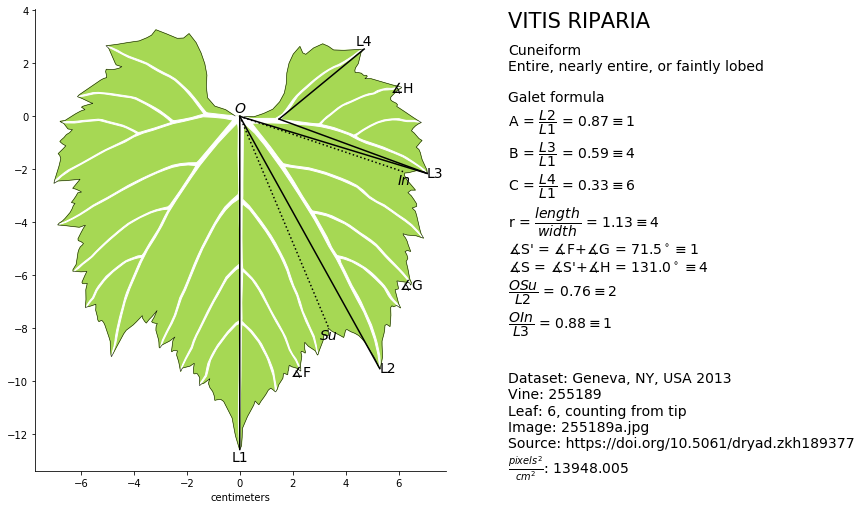

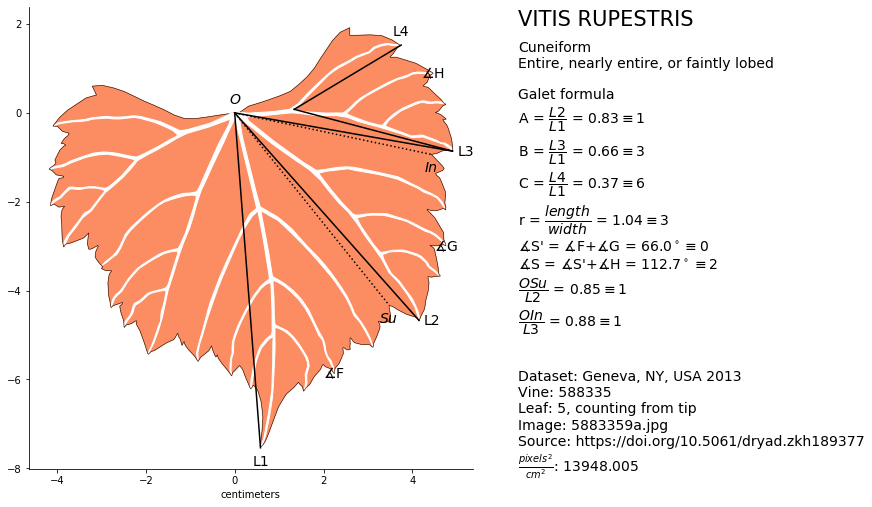

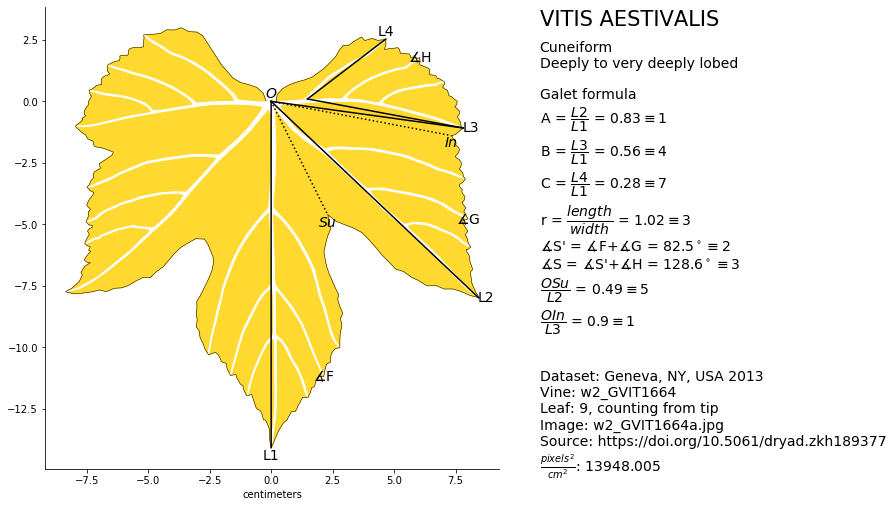

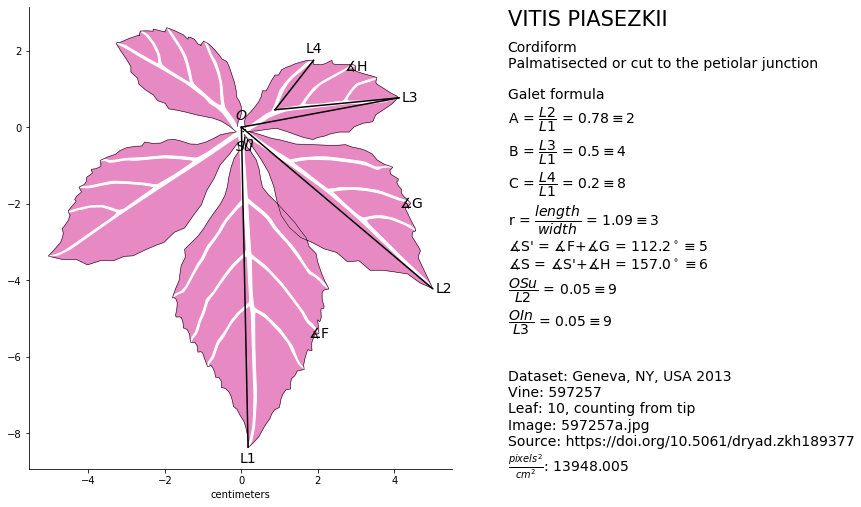

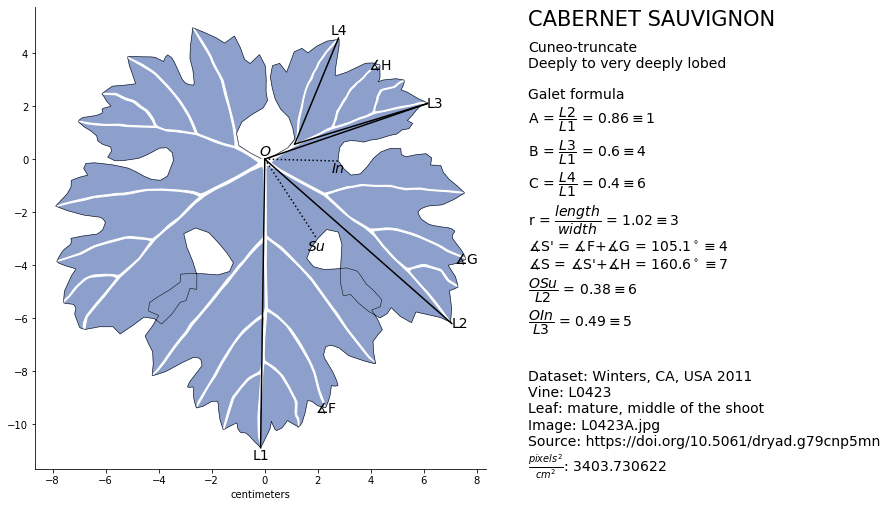

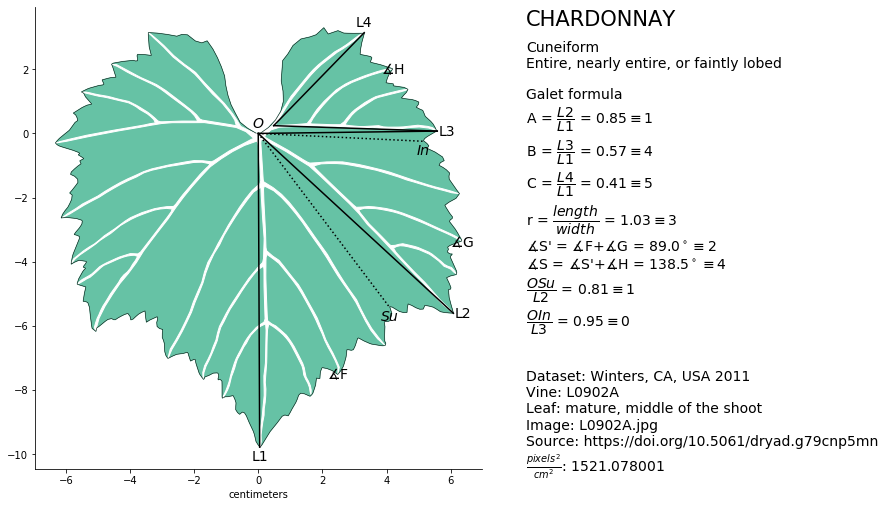

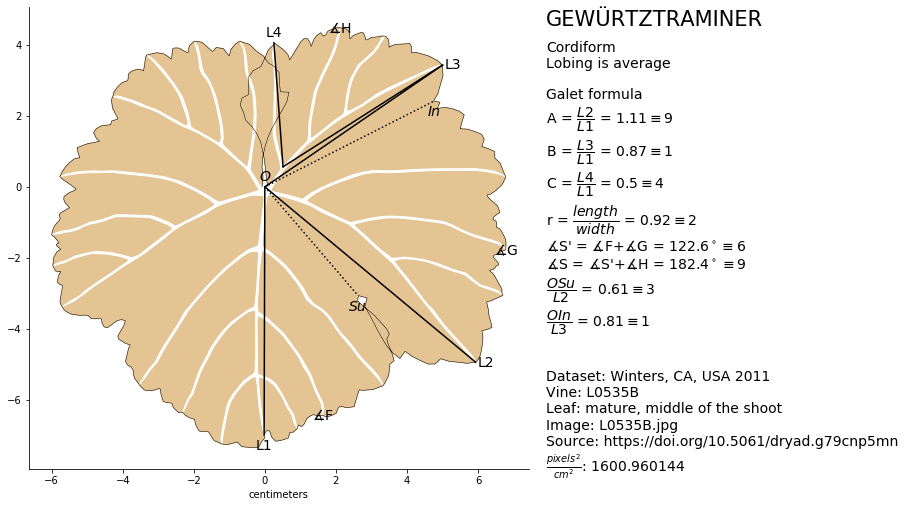

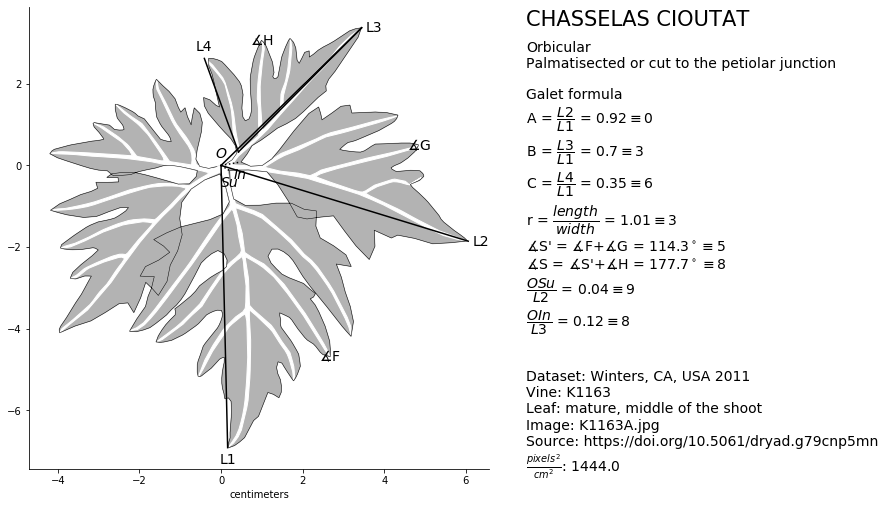

In [3]:
# a list with leaf IDs to read in and process data
leaf_list = ["VITISRIPARIA_0","VITISRUPESTRIS_0","VITISAESTIVALIS_0","VITISPIASEZKII_0",
             "CABERNETSAUVIGNON_0","CHARDONNAY_0","GEWURTZTRAMINER_0","CHASSELASCIOUTAT_0"]

# a list of colors for each species that correspond to morphospace
color_list = ["#a6d854", "#fc8d62", "#ffd92f", "#e78ac3",
                "#8da0cb", "#66c2a5", "#e5c494", "#b3b3b3" ]


for i in range(len(leaf_list)): # for each leaf in leaf_list

    curr_leaf = leaf_list[i]
    
    print(i, curr_leaf)

    # read in data from ./data folder

    landmarks = np.loadtxt("./data/" + curr_leaf + "_landmarks.txt") # landmark points
    vein_trace = np.loadtxt("./data/" + curr_leaf + "_veins.txt") # vein trace outline
    blade_trace = np.loadtxt("./data/" + curr_leaf + "_blade.txt") # blade trace outline
    info_df = pd.read_csv("./data/" + curr_leaf + "_info.csv") # read in metadata

    # unpack metadata
    
    species = info_df.iloc[0,1] 
    dataset = info_df.iloc[1,1]
    vine = info_df.iloc[2,1]
    leaf = info_df.iloc[3,1]
    image = info_df.iloc[4,1]
    source = info_df.iloc[5,1]
    px2_cm2 = float(info_df.iloc[6,1])
    
    # inputs for interpolation
    landmarks_file = landmarks
    vein_trace_file = vein_trace
    blade_trace_file = blade_trace
    num_land = 20
    resolution = 10000
    filename = curr_leaf
    
    # inputs for plot
    blade_color = color_list[i]
    blade_outline_color = "k"
    vein_color = "white"
    blade_outline_lw = 0.5
    text_position = 0.85 # position within trans.figure in which right text block appears, 0-1
    offset = 0.3 # offsets of text
    fontsize = 14
    linewidth = 1.5
    filename = curr_leaf
    
    ###############
    # PROCESS DATA
    ##############
    
    # create interpolated coordinates
    vein_xvals, vein_yvals, blade_xvals, blade_yvals = interpolated_leaf(landmarks_file, vein_trace_file, blade_trace_file, num_land, resolution)

    # scale, rotate, and translate coordinates
    scaled_land, scaled_vein, scaled_blade = rotate_and_scale(vein_xvals, vein_yvals, blade_xvals, blade_yvals, landmarks, px2_cm2, filename)

    # calculate ampelographic parameters
    leaf_type, sinus_type, A, B, C, r, Sp, S, Su_depth, In_depth, A_code, B_code, C_code, r_code, Sp_code, S_code, Su_code, In_code = galet_ampelography(scaled_land, scaled_vein, scaled_blade, blade_color, blade_outline_color, vein_color, blade_outline_lw, text_position, offset, fontsize, linewidth, filename)
    
    
